# Prep

In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
from skimage.exposure import adjust_gamma, equalize_adapthist
from skimage.morphology import disk

from src.fish import get_head
from src.fish import get_two_sides_img
from src.models import InputImage
from src.utils import normalize_0_255
from src.well import find_well_props

In [2]:
uniform_fig = (50, 40)

In [3]:
def plot_images(images, cols: int = None, count: int = None, fig: (int, int) = (16, 16), ticks=False, cmap='binary',
                title=None, hist=False, nums=False):
    if count is not None:
        images = images[0:count]

    l = len(images)

    if cols is None:
        cols = 4

    rows = int(l / cols)
    if l < cols: cols = l
    if l % cols != 0 or rows == 0:
        rows += 1

    fig, ax = plt.subplots(rows, cols, figsize=fig)
    ax = ax.ravel()
    for i, img in enumerate(images):
        if i >= l: return

        if nums: ax[i].set_title(f'#{i}')

        if not hist:
            ax[i].imshow(img, cmap)
            if not ticks:  # turn off ticks
                ax[i].get_xaxis().set_visible(False)
                ax[i].get_yaxis().set_visible(False)
        else:
            ax[i].hist(img.ravel(), bins=256)
    fig.suptitle(title, fontsize=56)
    plt.tight_layout()


def plot_fishes(fishes, cols: int = None, count: int = None, fig: (int, int) = (16, 16), ticks=False, cmap='binary'):
    images = list(map(lambda x: x.processed, fishes))  # Change this!
    plot_images(images, cols, count, fig, ticks, cmap)

# Run everything until eye exam

In [4]:
from src.fish import get_possible_fish

os.chdir('C:\\Users\\gimes\\source\\repos\\zebra_fishy\\src\\images\\in')
fish_names = os.listdir()
os.chdir('C:\\Users\\gimes\\source\\repos\\zebra_fishy\\src')
fishes = []

for name in fish_names:
    fishes.append(InputImage(name))

for i, fish in enumerate(fishes):
    print(f'#{i}')
    fish.processed = normalize_0_255(fish.processed)  # Normalizing intensity
    fish = find_well_props(fish)
    fish = get_possible_fish(fish)

#0
# Searching for well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Hough-transformation finished
_____________________________________________________________
# Creating circle mask for well
_____________________________________________________________
# Circle mask for well created
_____________________________________________________________
# Creating remaining masks:
_____________________________________________________________
# Creating cropped mask
_____________________________________________________________
# Creating masked image (original)
_____________________________________________________________
# Creating masked image (cropped)
_____________________________________________________________
# Created remaining masks
_____________________________________________________________
# Localizing potential embryo
_____________________________________

C:\Users\gimes\.miniconda\lib\site-packages\scipy\signal\signaltools.py:1611: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
C:\Users\gimes\.miniconda\lib\site-packages\scipy\signal\signaltools.py:1611: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


# Applying yen-threshold
_____________________________________________________________
# Removing meniscus
_____________________________________________________________
# Keeping only the possible fish
_____________________________________________________________
# Convex hull for mask
_____________________________________________________________
# Bounding box of fish
_____________________________________________________________
# Refining mask
_____________________________________________________________
# Convex hull for mask
_____________________________________________________________
# Bounding box from OG
_____________________________________________________________
#1
# Searching for well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Hough-transformation finished
_____________________________________________________________
# Creating circle mask for we

# Masks without eyes

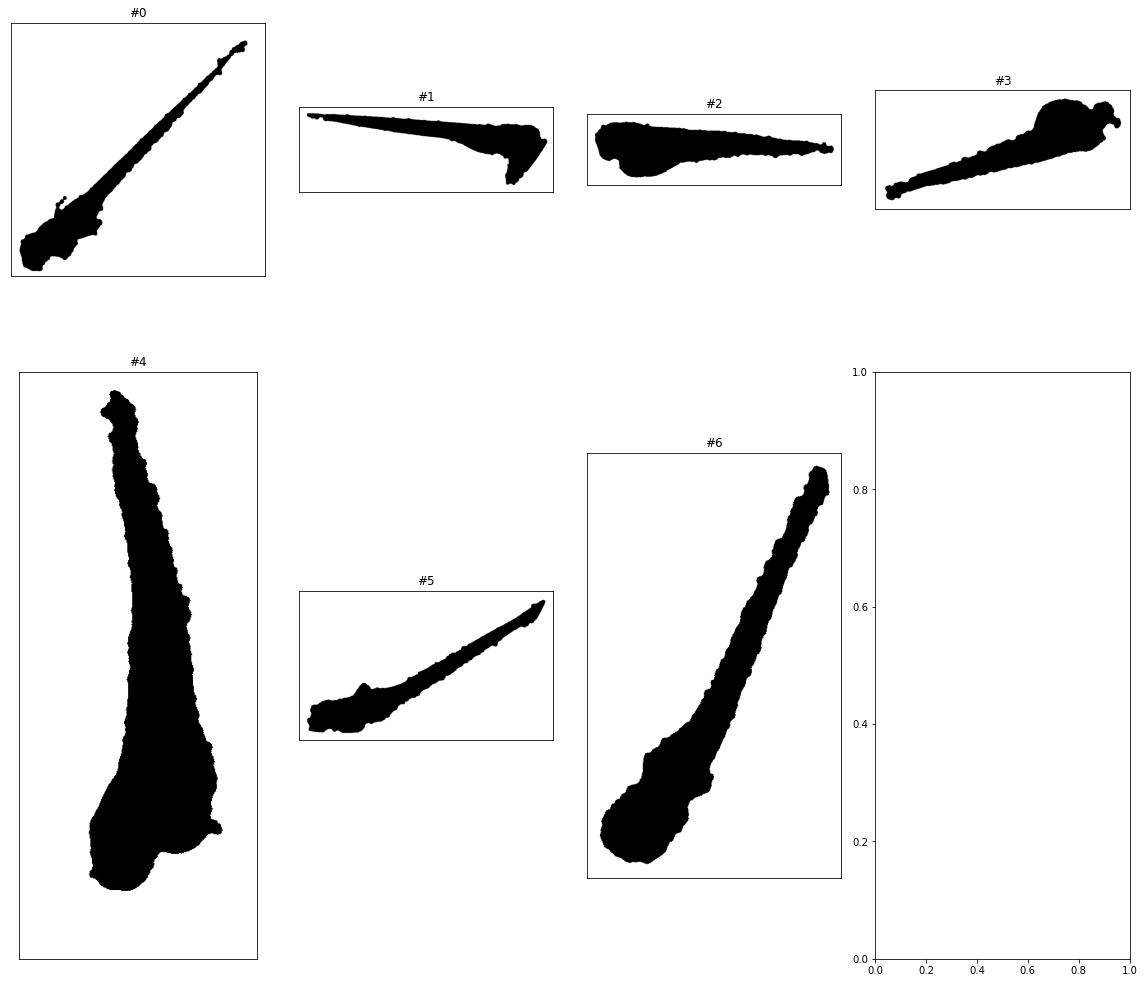

In [5]:
cropped = []
_close = []

for i, fish in enumerate(fishes):
    cropped.append(fish.fish_props.mask.cropped)
plot_images(cropped, cmap='binary', nums=True)

# END OF GET POSSIBLE FISH
____________
# Get head and apply mean intensity threshold

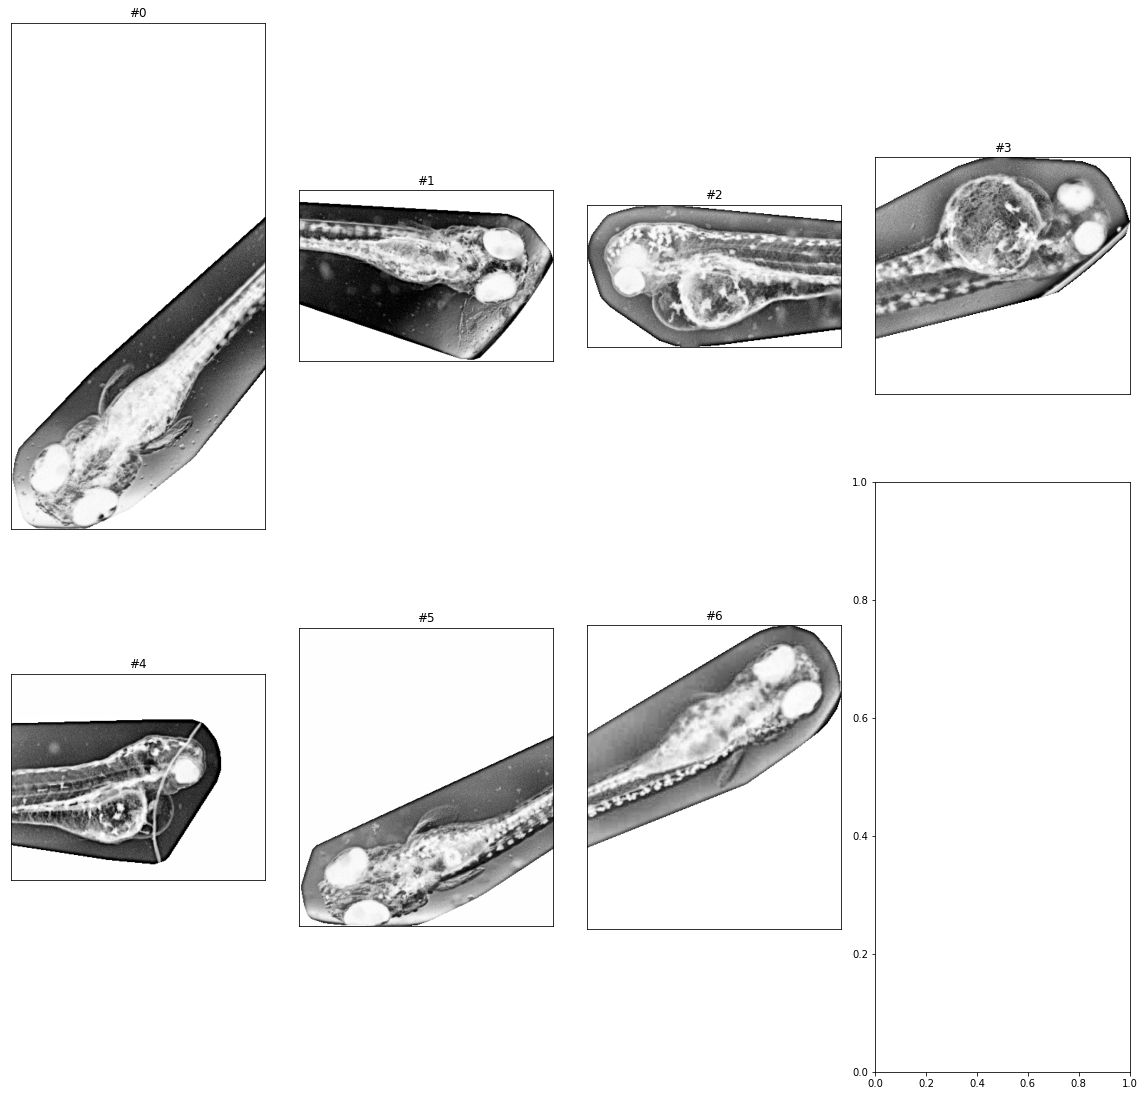

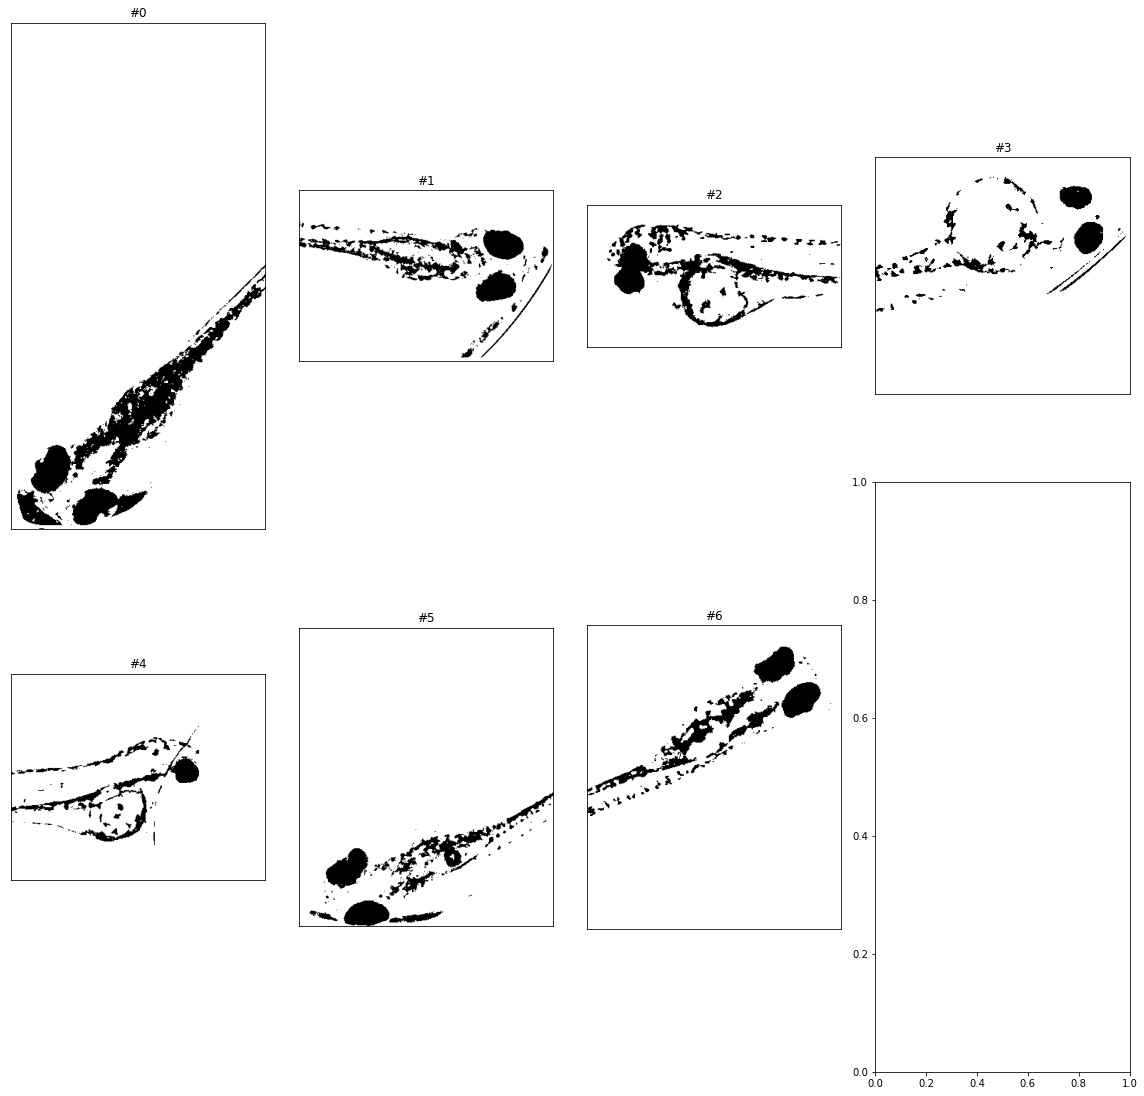

In [6]:
from src.utils import show_img
from skimage.filters._unsharp_mask import unsharp_mask

eyes = []
maskeds = []
maskes = []


def should_be_rotated(img: np.ndarray) -> bool:
    if img.shape[0] > img.shape[1]:
        print('Image is rotated!')
        return True
    return False


for i, fish in enumerate(fishes):

    # mask = fishes[i].fish_props.mask.cropped

    mask = fishes[i].fish_props.mask.og
    masked = adjust_gamma((unsharp_mask(fish.fish_props.cropped_og, radius=2.5) * mask), gamma=2)

    if fish.fish_props.rotated:
        masked = np.transpose(masked)
        mask = np.transpose(mask)

    sides = get_two_sides_img(masked)  #masked)
    sides_mask = get_two_sides_img(mask)
    sides_mask_ = get_two_sides_img(fish.fish_props.mask.cropped)

    #head, side = get_head(masked)
    head, side = get_head(fishes[i].fish_props.mask.cropped)
    if side == 'l':
        fish.fish_props.head = 'l'
        head = sides[0]
        head_mask = sides_mask[0]
        maskes.append(sides_mask_[0])
    else:
        fish.fish_props.head = 'r'
        head = sides[1]
        head_mask = sides_mask[1]
        maskes.append(sides_mask_[1])

    head = equalize_adapthist(head)

    mean = np.mean(head[head_mask != 0])

    th = (head < mean * 0.3) * head_mask

    #print(f'mean: {mean}')

    eyes.append(head)
    maskeds.append(th)

plot_images(eyes, cmap='binary', nums=True)
plot_images(maskeds, cmap='binary', nums=True)

# Remove unrelevant objects

In [8]:
from src.utils import keep_2_largest_object
from skimage.morphology import binary_dilation

eyess = []
hinds = []
largests = []

from src.fish import eye_spy, remove_hind_objects

for i, fish in enumerate(maskeds):
    print(f'#{i}')
    eye = eye_spy(fish)
    eyess.append(fish.astype(float) + eye.astype(float))

    no_hinds = remove_hind_objects(eye, fishes[i].fish_props.head)
    hinds.append(eye.astype(float) + no_hinds.astype(float))

    two_largest = keep_2_largest_object(no_hinds)
    two_largest = binary_dilation(two_largest, disk(4))

    largests.append(two_largest.astype(float))

#0
# Searching for eye regions
_____________________________________________________________
# Removing objects close to the middle of the embryo
_____________________________________________________________
#1
# Searching for eye regions
_____________________________________________________________
# Removing objects close to the middle of the embryo
_____________________________________________________________
#2
# Searching for eye regions
_____________________________________________________________
# Removing objects close to the middle of the embryo
_____________________________________________________________
#3
# Searching for eye regions
_____________________________________________________________
# Removing objects close to the middle of the embryo
_____________________________________________________________
#4
# Searching for eye regions
_____________________________________________________________
# Removing objects close to the middle of the embryo
______________________

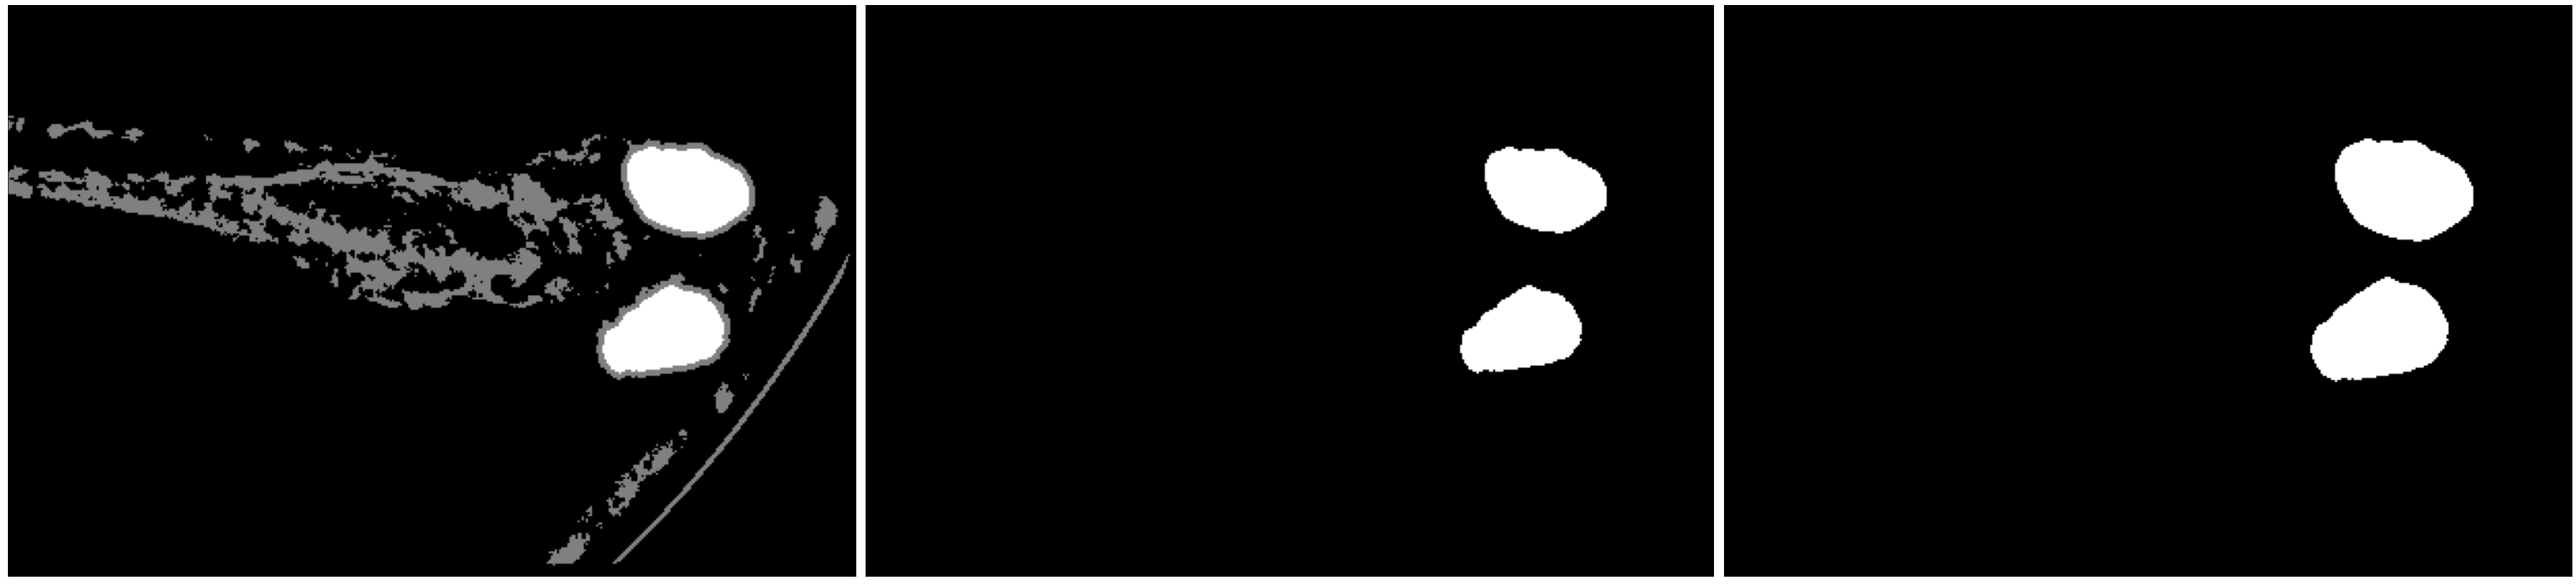

In [15]:
i = 1
plot_images([eyess[i], hinds[i], largests[i]], 3,fig= (50,30),cmap="gray")

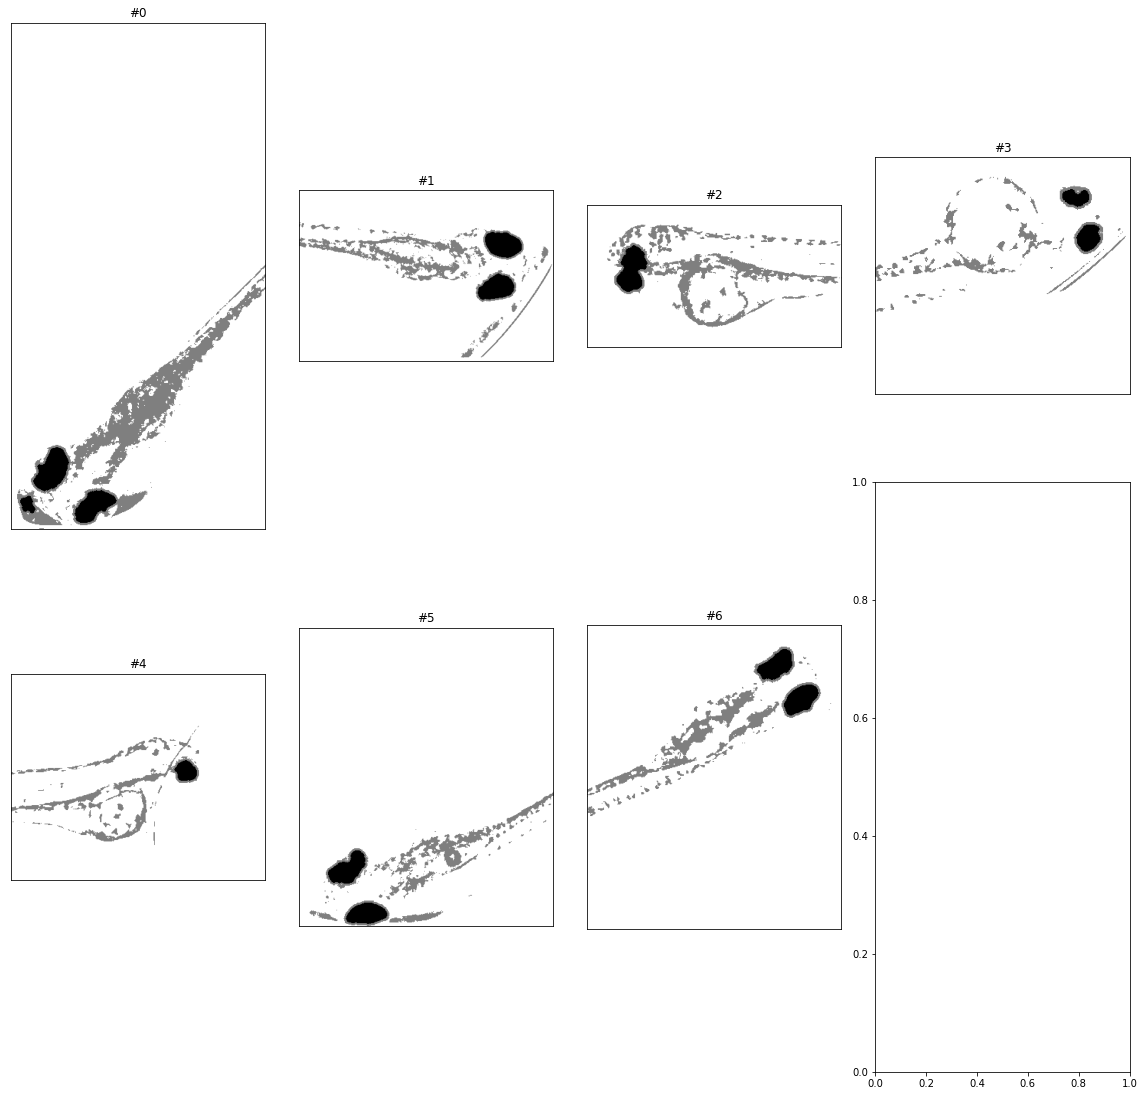

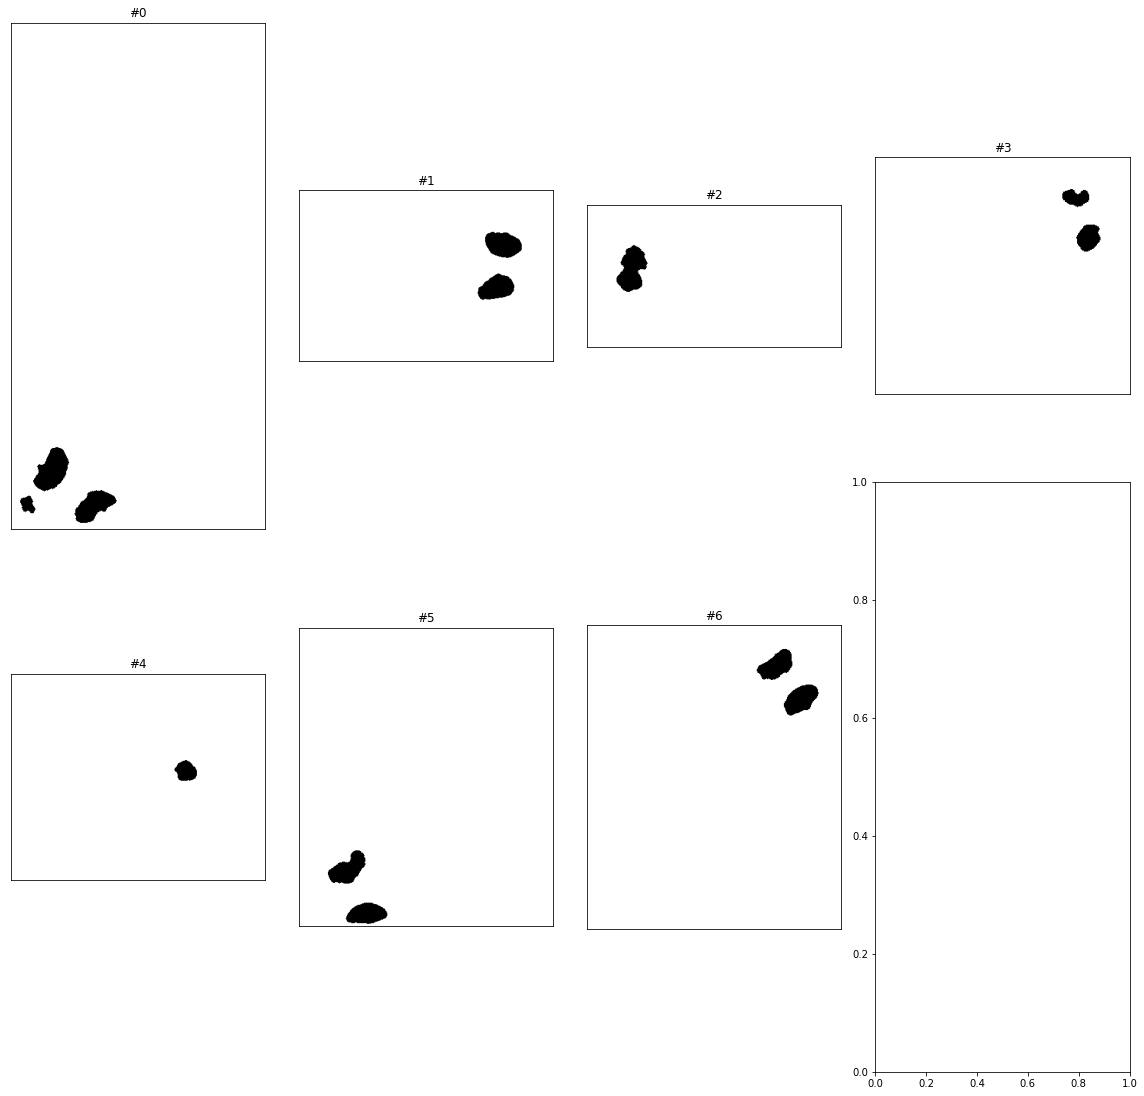

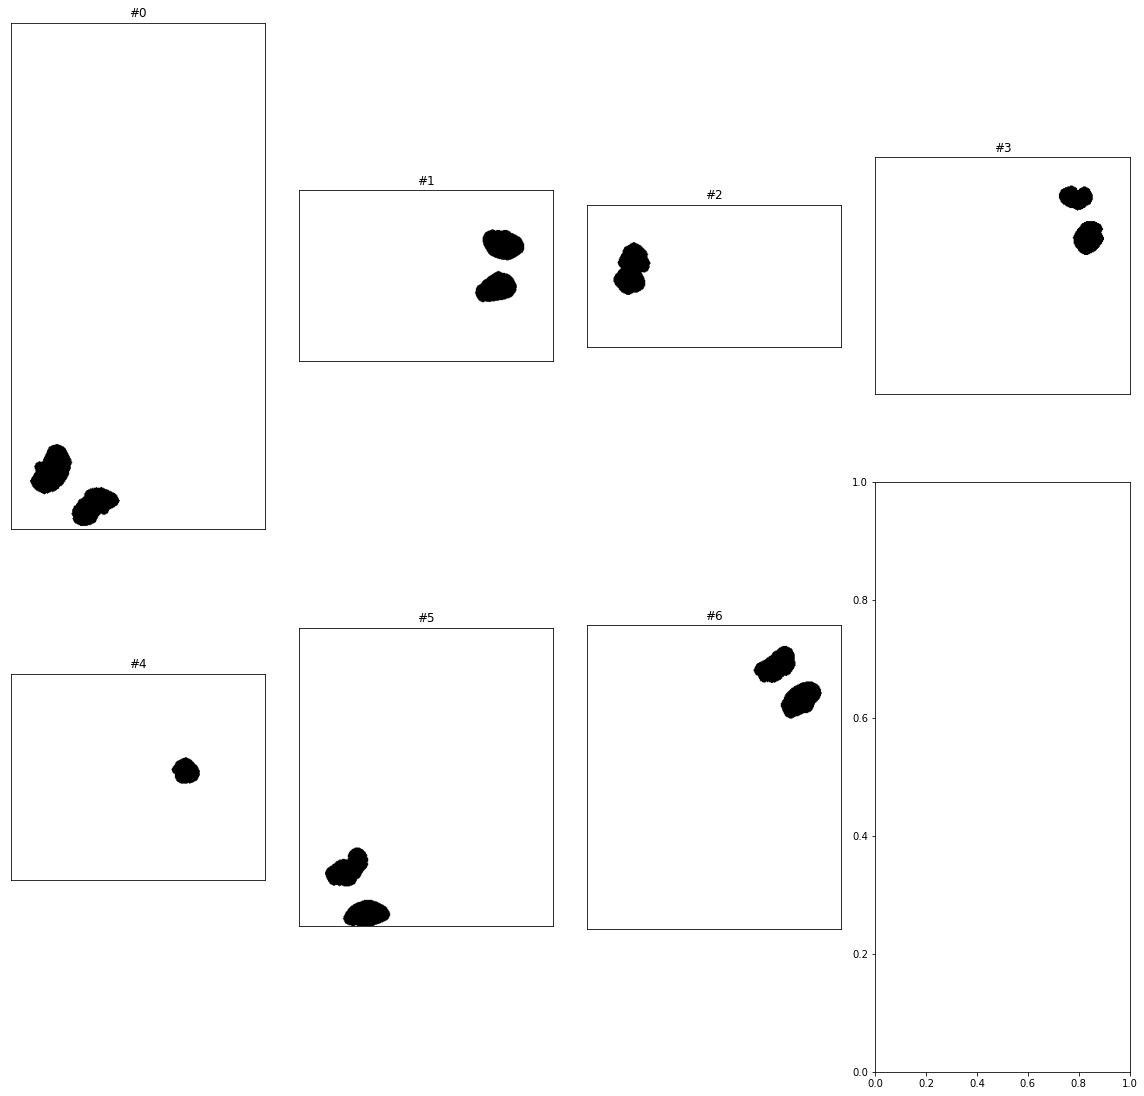

In [9]:
plot_images(eyess, nums=True)
plot_images(hinds, nums=True)
plot_images(largests, nums=True)